In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_spectral_clustering_elbows  
from src.utils import preprocess_sales_matrix, compute_spectral_clustering_cv_scores, generate_store_item_clusters



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-10'

In [4]:
# load
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3612587674.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [5]:
df['onpromotion'].unique()

[autoreload of src.utils failed: Traceback (most recent call last):
  File "/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/yvesgreatti/.pyenv/versions/3.12.9/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1133, in get_code
  File "<frozen importlib._bootstrap_external>", line 1063, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/yvesgr

array([nan, False, True], dtype=object)

In [6]:
df["date"] = pd.to_datetime(df["date"])
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["weekofyear"] = df["date"].dt.isocalendar().week
df

,date,store_item,store,item,unit_sales,onpromotion,dayofweek,month,weekofyear
0,2013-01-07,48_502331,48,502331,70.00000,NaN,0,1,2
1,2013-01-07,46_584028,46,584028,304.27301,NaN,0,1,2
2,2013-01-07,3_114790,3,114790,28.00000,NaN,0,1,2
3,2013-01-07,3_305229,3,305229,89.00000,NaN,0,1,2
4,2013-01-07,3_314384,3,314384,106.00000,NaN,0,1,2
...,...,...,...,...,...,...,...,...,...
167299,2017-08-15,51_567623,51,567623,17.00000,False,1,8,33
167300,2017-08-15,51_581078,51,581078,30.00000,False,1,8,33
167301,2017-08-15,49_567623,49,567623,29.00000,False,1,8,33
167302,2017-08-15,49_502331,49,502331,61.00000,False,1,8,33


In [7]:

# Example: aggregate by dayofweek
store_clust_df = df.groupby(["store", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
store_clust_df

dayofweek,0,1,2,3,4,5,6
store,,,,,,,
3,233570.000000,209779.796875,222306.640625,185392.187500,246333.171875,273905.562500,308513.218750
8,123916.125000,110393.945312,122429.359375,101608.757812,124284.664062,158697.484375,159207.921875
44,247985.062500,230354.328125,250904.453125,200176.156250,247772.234375,336211.843750,371586.156250
45,218743.031250,185280.390625,181881.312500,156743.156250,212145.250000,274127.156250,321355.187500
46,209582.734375,168207.140625,164661.531250,146260.343750,194636.093750,289264.406250,334705.500000
47,206874.843750,177894.718750,181773.062500,152471.328125,193998.109375,263051.031250,309905.218750
48,169767.390625,150193.250000,143515.343750,134474.906250,191967.359375,241970.062500,297513.625000
49,128484.945312,109929.429688,116373.984375,96394.640625,142145.687500,151233.468750,171850.015625
50,149377.453125,135116.390625,139277.343750,126378.039062,147743.406250,185885.468750,200905.296875


In [8]:
X, pivot_clean = preprocess_sales_matrix(store_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


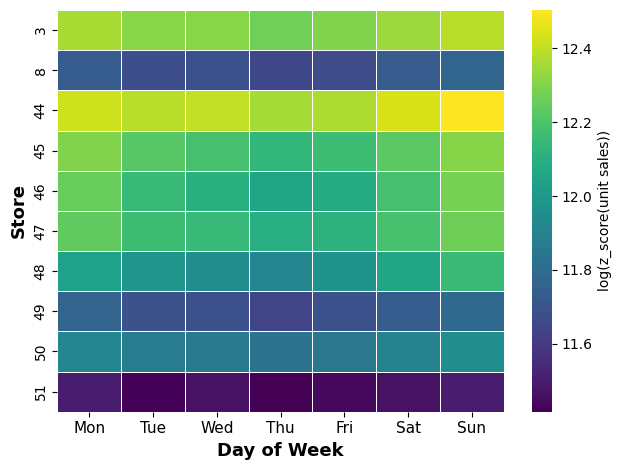

In [9]:

day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Store",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/2025-06-07_heatmap_store_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()



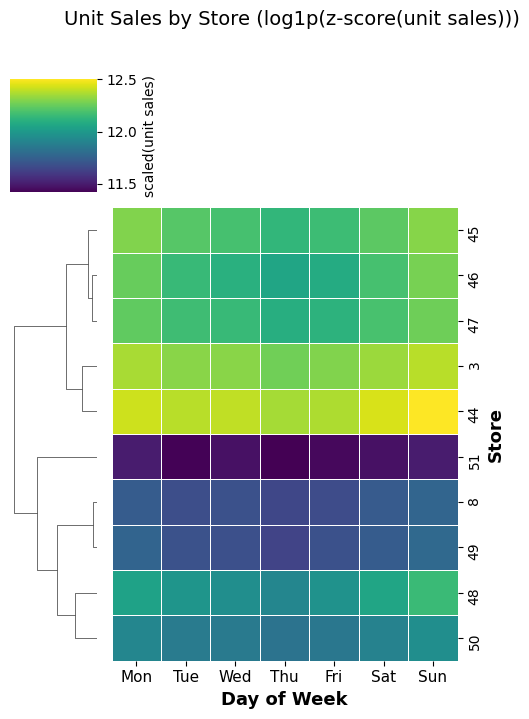

In [19]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Store",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Store (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)

# ---------------------------------------------------------------------
# FIRST let matplotlib tighten up everything *else* …
# ---------------------------------------------------------------------
#grid.figure.tight_layout(rect=[0, 0, 0.88, 1])     # leave room on the right

# ---------------------------------------------------------------------
# … THEN move / resize the colour‑bar
# ---------------------------------------------------------------------

# optional: put tick labels on the outside
#grid.cax.yaxis.set_label_position('right')
grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/2025-06-07_clustered_store_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [25]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,42.022753,0.541314,NaN
1,3,NaN,58.289140,0.225026,NaN
2,4,NaN,79.633059,0.458693,NaN
3,5,NaN,78.637807,0.458693,NaN
4,6,NaN,83.910748,0.445367,NaN


In [21]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,63.539831,0.541314,NaN
1,3,NaN,55.149080,0.392015,NaN
2,4,NaN,67.576050,0.392015,NaN
3,5,NaN,75.310768,0.177420,NaN
4,6,NaN,84.248961,0.458693,NaN


In [28]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,36.404406,0.541314,NaN
1,3,NaN,51.316306,0.541314,NaN
2,4,NaN,52.517374,0.177420,NaN
3,5,NaN,88.013466,0.445367,NaN
4,6,NaN,91.179629,0.445367,NaN


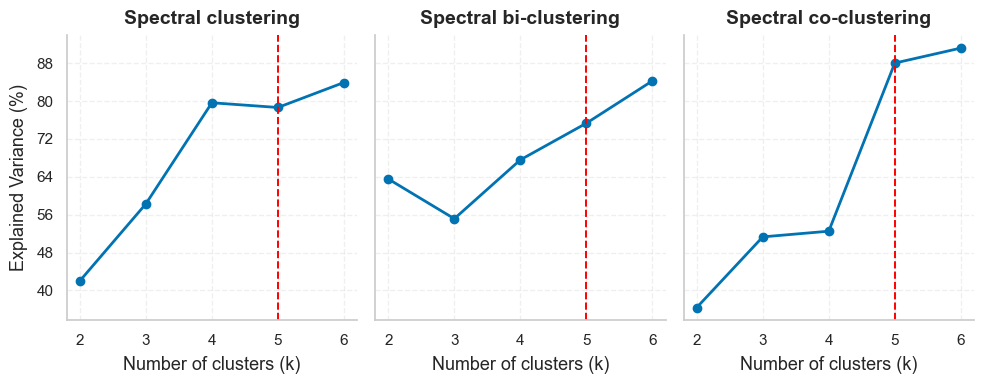

In [35]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_store_spectral_clustering_elbow.tiff")

In [36]:
store_clusters = generate_store_item_clusters(pivot_clean, n_clusters=5, model_class=SpectralClustering)
store_clusters

,store_item,clusterId
0,3,3
1,8,1
2,44,3
3,45,2
4,46,2
5,47,4
6,48,0
7,49,1
8,50,0
9,51,1


In [52]:
store_clusters.to_excel("../output/data/20250610_store_clusters.xlsx", index=False)


In [39]:
item_clust_df = df.groupby(["item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
item_clust_df

dayofweek,0,1,2,3,4,5,6
item,,,,,,,
114790,65934.00000,58541.000000,61027.000000,49694.000000,59724.00000,92168.000000,104334.000000
305229,100526.00000,87752.000000,96594.000000,77143.000000,94014.00000,113315.000000,126298.000000
314384,208535.00000,178413.000000,187639.000000,148368.000000,181779.00000,286893.000000,331265.000000
364606,233280.00000,206453.000000,218815.000000,177461.000000,195605.00000,278954.000000,326067.000000
502331,174052.00000,139167.000000,140516.000000,118401.000000,136309.00000,200200.000000,269012.000000
567623,80895.00000,65895.000000,66624.000000,52940.000000,61229.00000,100220.000000,135745.000000
581078,70016.00000,64095.000000,71520.000000,58879.000000,71888.00000,88769.000000,92420.000000
582864,148046.03125,131828.734375,130798.570312,123210.703125,262692.65625,173113.109375,183678.265625
584028,291425.68750,257868.406250,257720.062500,234997.234375,334694.56250,342394.843750,372661.968750


In [40]:
X, pivot_clean = preprocess_sales_matrix(item_clust_df, log_transform=True, smooth_window=16, zscore_rows=True)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/utils.py:421: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  df = df.rolling(window=smooth_window, axis=1, min_periods=1).mean()


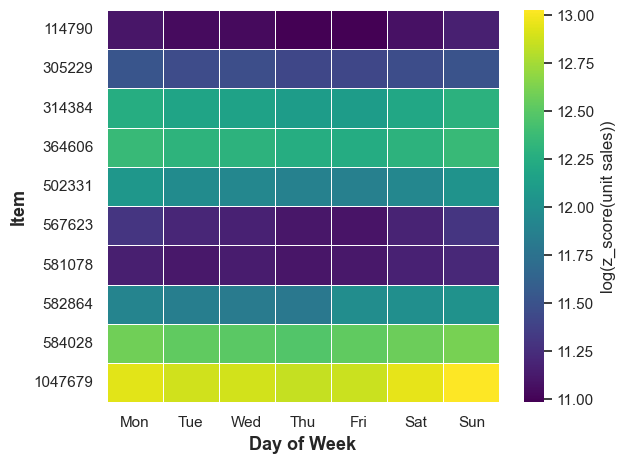

In [41]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
norm = plt.Normalize(vmin=pivot_clean.values.min(),
                     vmax=pivot_clean.values.max())


ax = sns.heatmap(
    pivot_clean,
    cmap="viridis",
    linewidths=.5,          # thin separator lines
    linecolor="white",
cbar_kws={"label": "log(z_score(unit sales))"}
)

ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week", fontsize=13, fontweight="bold")
ax.set_ylabel("Item",       fontsize=13, fontweight="bold")

plt.tight_layout()
fn = "../output/figures/20250610_heatmap_item_sales_matrix.tiff"
plt.savefig(fn, dpi=300)
plt.show()
plt.close()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:34: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.tight_layout(rect=[0, 0, 0.88, 1])
/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_17412/3335997768.py:40: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  grid.figure.savefig(fn, dpi=300    )
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


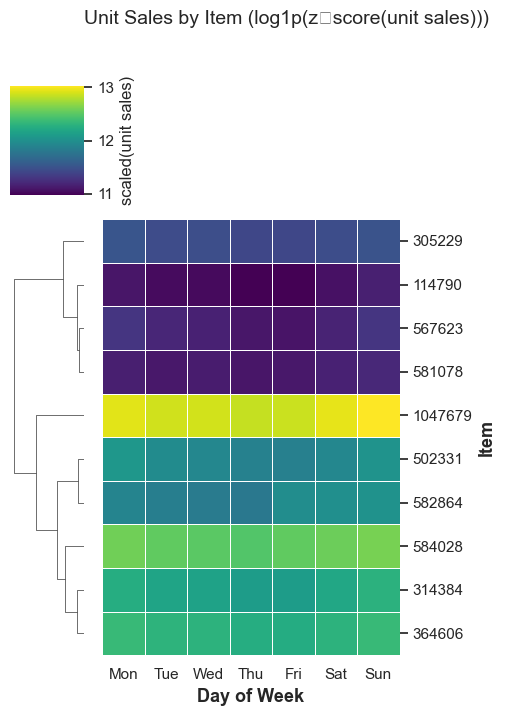

In [42]:
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# ---------------------------------------------------------------------
# build the clustermap
# ---------------------------------------------------------------------
grid = sns.clustermap(
    pivot_clean,
    cmap="viridis",
    row_cluster=True,
    col_cluster=False,          # keep Mon→Sun order
    linewidths=.4, linecolor="white",
    figsize=(6, 7),
  #      cbar_pos=(0.90, 0.20, 0.03, 0.65),   # [x, y, width, height]
    cbar_kws={
        "label": "scaled(unit sales)",
        "orientation": "vertical",   # just to be explicit
    }
)

# tidy up the heat‑map axis
ax = grid.ax_heatmap
ax.set_xticklabels(day_names, rotation=0, fontsize=11)
ax.set_xlabel("Day of Week",  fontsize=13, fontweight="bold")
ax.set_ylabel("Item",        fontsize=13, fontweight="bold")

# overall title (use the figure, not the heat‑map axis)
grid.figure.suptitle(
    "Unit Sales by Item (log1p(z‑score(unit sales)))",
    fontsize=14, y=1.02
)


grid.cax.yaxis.tick_right()
grid.figure.tight_layout(rect=[0, 0, 0.88, 1])

# ---------------------------------------------------------------------
# save / show
# ---------------------------------------------------------------------
fn = "../output/figures/20250610_clustered_item_sales_matrix.tiff"
grid.figure.savefig(fn, dpi=300    )
plt.show()
plt.close()


In [44]:
results_spectral_clustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralClustering,
    n_clusters_row_range=range(2, 8),
    cv_folds=3
)
results_spectral_clustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-p

Evaluating n_row=5
Evaluating n_row=6


/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:372: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/Users/yvesgreatti/.pyenv/versions/3.12.9/envs/interviews/lib/python3.12/site-packages/sklearn/cluster/_spectral.py:703: UserWarning:

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,59.052952,0.502932,NaN
1,3,NaN,86.294428,0.297913,NaN
2,4,NaN,88.017222,0.482839,NaN
3,5,NaN,90.963996,0.514127,NaN
4,6,NaN,91.246928,0.514127,NaN


In [45]:
results_spectral_biclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralBiclustering,
    n_clusters_row_range=range(2, 7),  
    cv_folds=3
)
results_spectral_biclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,29.414937,0.502932,NaN
1,3,NaN,50.118215,0.585602,NaN
2,4,NaN,82.861211,0.585602,NaN
3,5,NaN,87.247744,0.236738,NaN
4,6,NaN,87.247744,0.236738,NaN


In [46]:
results_spectral_coclustering = compute_spectral_clustering_cv_scores(
    data=pivot_clean.values,
    model_class=SpectralCoclustering,
    n_clusters_row_range=range(2, 8),  
    cv_folds=3
)
results_spectral_coclustering

Evaluating n_row=2
Evaluating n_row=3
Evaluating n_row=4
Evaluating n_row=5
Evaluating n_row=6


,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,2,NaN,13.132559,0.248948,NaN
1,3,NaN,29.572957,0.502932,NaN
2,4,NaN,31.210978,0.502932,NaN
3,5,NaN,79.531610,0.514127,NaN
4,6,NaN,93.000911,0.585602,NaN


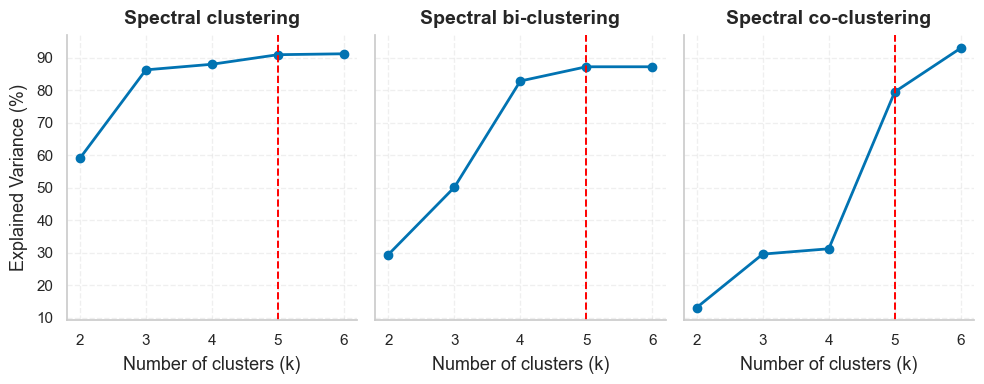

In [48]:
plot_spectral_clustering_elbows([results_spectral_clustering, results_spectral_biclustering, results_spectral_coclustering], 
                                titles=["Spectral clustering", 
                                        "Spectral bi-clustering", 
                                        "Spectral co-clustering"], 
                                vline_x=5,
                                fn="../output/figures/20250610_item_spectral_clustering_elbow.tiff")

In [49]:
item_clusters = generate_store_item_clusters(pivot_clean, n_clusters=4, model_class=SpectralClustering)
item_clusters

,store_item,clusterId
0,114790,1
1,305229,3
2,314384,2
3,364606,2
4,502331,3
5,567623,1
6,581078,1
7,582864,3
8,584028,2
9,1047679,0


In [50]:
item_clusters.to_excel("../output/data/20250610_item_clusters.xlsx", index=False)

In [ ]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(20, 30),   # Try 2 to 7 row clusters
    Q_range=range(20, 30),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


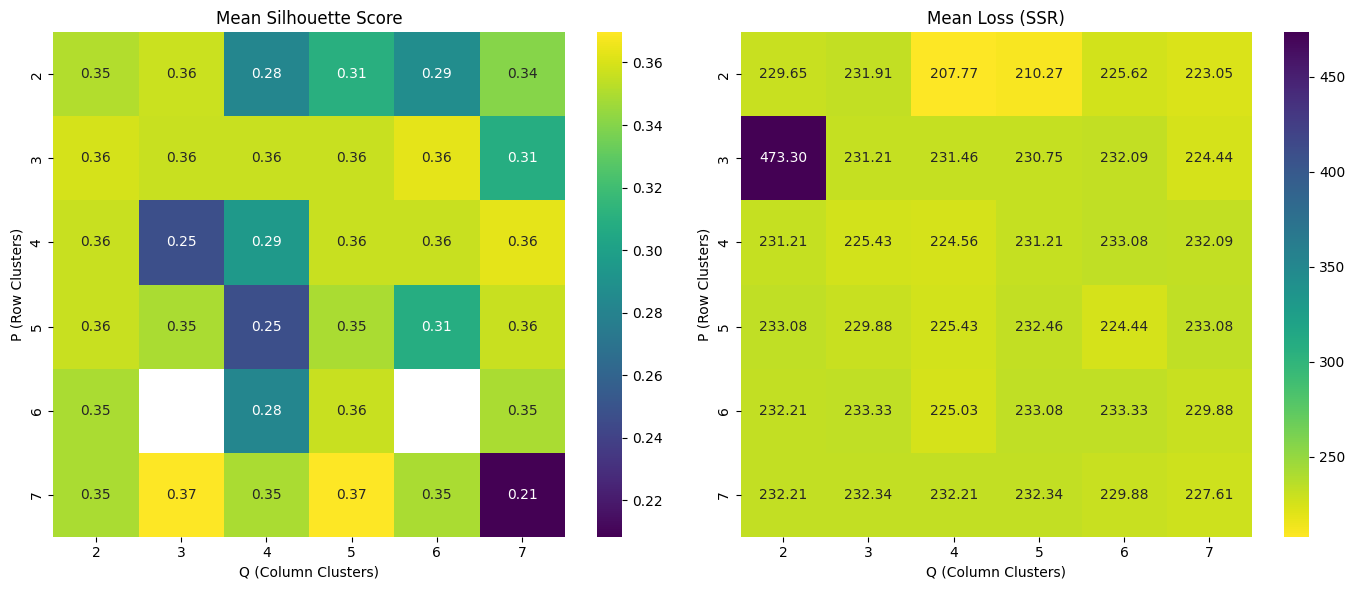

In [24]:
visualize_gdkm_cv_scores(results_df)

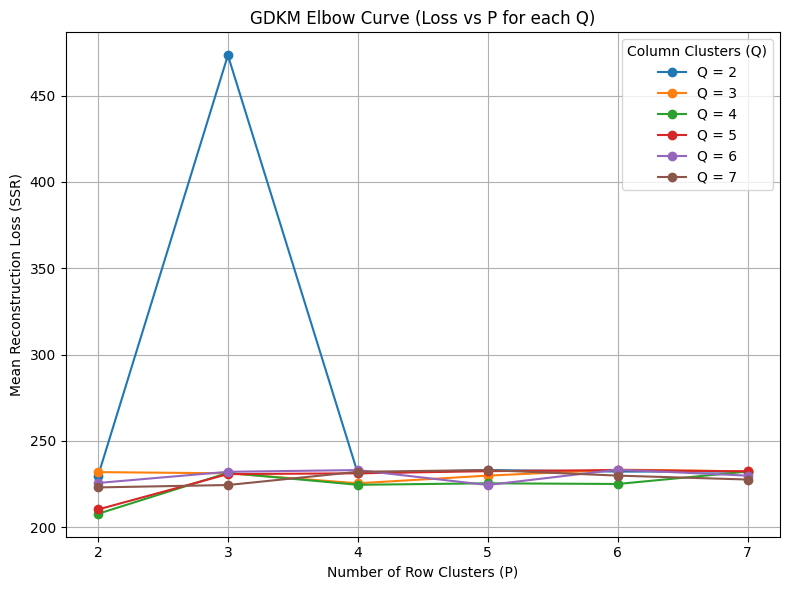

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
